In [1]:
import sys
sys.path.insert(0, '../')

import os
import pandas as pd
import numpy as np
import numpy
import typing

import matplotlib.pyplot as plt
import sklearn
import scipy

from typing import Tuple
from pickle import load, dump
from glob import glob
from sklearn.model_selection import train_test_split
from typing import Tuple
import scipy.stats as stats

from src.vg2signal import read_raw_vg_as_df, make_smoother, make_shoulder_getter, make_detilter, find_first_derivative_peaks, make_signal_getter
from src.load_dataset import load_dataset
from src.generate_dataset import make_xlsx_str

In [2]:
def v2signal_extra_features(vg_filename: str,
             do_log: bool,
             smoothing_bw: float,
             vcenter: float,
             vwidth: float,
             stiffness: float,
             noise=None,
             flip_signal=False,
             clip_signal=False,
             show_negative_peak_signal=False):

    vg_df = read_raw_vg_as_df(vg_filename)

    if (vg_df['I'].to_numpy() < 0).any():
        temp = [None] * 11
        return [None, None, vg_df] + temp

    if do_log:
        cur_var_name = "logI"
        #vg_df[cur_var_name] = np.emath.logn(logbase, vg_df["I"])
        vg_df[cur_var_name] = np.log2(vg_df["I"])
    else:
        cur_var_name = "I"

    smoother = make_smoother(smoothing_bw)

    vg_df["smoothed"] = smoother(vg_df["V"], vg_df[cur_var_name].to_numpy())

    shoulder_getter = make_shoulder_getter(1, 1.1)
    (roots_ddd, peak_v_shoulder) = shoulder_getter(vg_df["V"],
                                                     vg_df["smoothed"])

    vcenter = peak_v_shoulder
    vstart = vcenter - 0.5*vwidth
    vend   = vcenter + 0.5*vwidth

    detilter = make_detilter(vstart, vend, stiffness)
    vg_df["detilted"] = detilter(vg_df["V"].to_numpy(),
                                 vg_df["smoothed"].to_numpy())

    if flip_signal:
        if abs(vg_df['detilted'].min()) > abs(vg_df['detilted'].max()):
            print(vg_filename)
            #vg_df['detilted'] = -vg_df['detilted'] # Flip the signal if negative

    if clip_signal:
        vg_df['detilted'] = vg_df['detilted'].clip(lower=0.0)
        if vg_df['detilted'].sum()==0:
            return 0, 0, 0, vg_df, vcenter, 0, 0, 0,\
           0, 0, 0, 0, 0, 0

    if show_negative_peak_signal:
        if np.abs(vg_df['detilted'].min()) > np.abs(vg_df['detilted'].max()):
            print("Negative peak", os.path.basename(vg_filename))

    # Add Noise to the dataset
    if noise=='gaussian':
        section = vg_df["detilted"][(vg_df['V']<1.15) & (vg_df['V']>0.93)]
        print(section.std())
        section += np.random.normal(0.0005, 0.001, len(section))
        
        vg_df["detilted"][(vg_df['V']<1.15) & (vg_df['V']>0.93)] = section
    
    # print(vg_df["detilted"].shape, vg_df["smoothed"].shape)

    signal_getter = make_signal_getter(vstart, vend)
    (peak_signal_return, peak_v_return) = signal_getter(vg_df["V"], vg_df["detilted"])
    ymaxidx = np.argmax(vg_df["detilted"])

    peakarea = sklearn.metrics.auc(vg_df["V"], vg_df["detilted"])*1000

    V, dS_dV, dS_dV_max_peak, dS_dV_min_peak, dS_dV_peak_diff, \
    dS_dV_max_V, dS_dV_min_V, dS_dV_area        = find_first_derivative_peaks(vg_df["V"].values, vg_df["detilted"].values)

    signal_std  = vg_df["detilted"].values.std()
    signal_mean = vg_df["detilted"].values.mean()
    
   
    return  peakarea, peak_signal_return, peak_v_return, vg_df, vcenter, vg_df["detilted"][ymaxidx], signal_mean, signal_std,\
           dS_dV_max_peak, dS_dV_min_peak, dS_dV_peak_diff, dS_dV_max_V, dS_dV_min_V, dS_dV_area


def run_vg2(folderpaths: str, 
            do_log:bool, 
            recenter:bool, 
            smoothing_bw:float, 
            stiffness:float, 
            vcenter:float, 
            vwidth1:float, 
            vwidth2:float,
            noise=None,
            flip_signal=False,
            clip_signal=False,
            show_negative_peak_signal=False,
            savefilename = 'extracted_features') -> Tuple[dict, str]:
    
    # get filenames to save
    data_str = make_xlsx_str(do_log, recenter, smoothing_bw, stiffness, vcenter, vwidth1, vwidth2)
    vg_dict  = dict()
    dfxl     = pd.DataFrame()


    os.chdir(os.path.dirname(folderpaths[0]))  # change to desired folderpath

    signal_lst = []       # Store all the features
    conc_dict = dict()    # [cbz concentration]: peak signals

    for filename in folderpaths:
        
        if filename[-3:] == 'txt':
            #print("Analyzing:", filename)
            (peak_signal, peak_curvature, peak_v, vg_df, vcenter, ph, signal_mean, signal_std,\
                dS_dV_max_peak, dS_dV_min_peak, dS_dV_peak_diff, dS_dV_max_V, \
                dS_dV_min_V, dS_dV_area) = v2signal_extra_features(os.path.basename(filename),
                                                                    do_log,
                                                                    smoothing_bw,
                                                                    vcenter,
                                                                    vwidth1,
                                                                    stiffness,
                                                                    noise,
                                                                    flip_signal,
                                                                    clip_signal,
                                                                    show_negative_peak_signal)
            
            if (peak_signal == None) or (peak_curvature==None):
                #print(f"peak_signal:{peak_signal} OR peak curvature: {peak_curvature}", filename)
                continue

            idx1 = filename.rfind("cbz")
            idx2 = filename[idx1:].find("_")
            conc = filename[idx1 + 3:idx1 + idx2]
            replicate = filename[idx1 + idx2 + 1:filename.rfind(".")]

            # for 7p5 concentration
            if 'p' in conc:  
                pi = conc.find('p')
                conctemp = conc[:pi] + '.' + conc[pi + 1:]
                conc = conctemp

            concstrxl   = str(float(conc))
            concxl      = list([concstrxl] * len(vg_df["V"]))
            replicatexl = list([replicate] * len(vg_df["V"]))

            if do_log:
                dfxl = pd.concat([dfxl, pd.DataFrame(
                    [concxl, replicatexl, vg_df["V"], vg_df["I"], vg_df["logI"], vg_df["smoothed"],
                     vg_df["detilted"]]).transpose()])
            else:
                dfxl = pd.concat([dfxl, pd.DataFrame(
                    [concxl, replicatexl, vg_df["V"], vg_df["I"], vg_df["smoothed"], vg_df["detilted"]]).transpose()])

            if peak_signal is None: peak_signal = 0 # if find no peak
            if peak_v is None: peak_v = 0           # if find no peak V

            signal_lst.append([filename, round(peak_signal, 4), round(peak_curvature, 4), round(peak_v, 4), round(vcenter, 4), ph, round(signal_mean, 4), round(signal_std, 4),\
                              round(dS_dV_max_peak, 4), round(dS_dV_min_peak, 4), round(dS_dV_peak_diff, 4), round(dS_dV_max_V, 4), round(dS_dV_min_V, 4), round(dS_dV_area, 4)])  # add text filename & peak signal to signal list
            
             # for each concentration
            if conc in conc_dict.keys(): 
                conclst = conc_dict[conc]
                conclst.append((peak_signal, peak_v))  # add peak signal to concentration dictionary
                conc_dict[conc] = conclst

                # for plotting purposes
                plst = vg_dict[conc]
                plst.append(vg_df)
                vg_dict[conc] = plst
            
            else:
                conc_dict[conc] = [(peak_signal, peak_v)]
                vg_dict[conc] = [vg_df]

    signal_df = pd.DataFrame(signal_lst)
    conc_list = []
    concs_targetlst = sorted([c for idx, c in enumerate(list(conc_dict.keys()))], key=lambda v: float(v))

    # for each concentration
    for key in conc_dict:  
        vals       = conc_dict[key]                                  # all the signals for conc
        avgval     = round(np.average([val[0] for val in vals]), 2)  # avg signal for conc
        stdval     = round(np.std([val[0] for val in vals]), 2)      # std of signals for conc
        avgpeakval = round(np.average([val[1] for val in vals]), 2)  # avg peak voltage for conc
        stdpeakval = round(np.std([val[1] for val in vals]), 2)      # std of peak voltage for conc
        
        if avgval != 0:
            cvval  = round(stdval / avgval, 3)
        
        else:
            cvval = 0  # if average is 0, make CV 0
        
        concstr = str(float(key)) + " \u03BCM"
        # compare signal list for this conc to closest lower conc
        currentidx = concs_targetlst.index(key)
        if currentidx == 0:
            lowervals = conc_dict[key]
        else:
            lowervals = conc_dict[concs_targetlst[currentidx-1]]
        ttest = round(stats.ttest_ind([val[0] for val in vals], [val[0] for val in lowervals], equal_var=False)[0], 2)
        conc_list.append([concstr, avgval, stdval, cvval, ttest, avgpeakval, stdpeakval])  # add stats for conc

    conc_lst_sorted = sorted(conc_list, key=lambda x: float(x[0][:-2]))
    conc_df = pd.DataFrame(conc_lst_sorted)
    
    # save stats list to excel
    stats_str     = "stats" + data_str
    signal_str    = f"{savefilename}.xlsx"
    dataframe_str = "dataframe" + data_str

    conc_df.to_excel(stats_str, index=False,
                     header=["conc", "average", "std", "CV", "T-Statistic", "avg peak", "std peak"])
    signal_df.to_excel(signal_str, index=False,
                       header=["file", "peak area", "peak curvature", "peak V", "vcenter", "PH", "signal_mean", "signal_std", \
                              "dS_dV_max_peak", "dS_dV_min_peak", "dS_dV_peak_diff", "dS_dV_max_V", "dS_dV_min_V", "dS_dV_area"])  # save signal list to excel
    if do_log:
        dfxl.to_excel(dataframe_str, index=False,
                      header=["conc", "replicate", "V", "I", "logI", "smoothed", "detilted"])
    else:
        dfxl.to_excel(dataframe_str, index=False, header=["conc", "replicate", "V", "I", "smoothed", "detilted"])
    
    return signal_df

In [3]:
do_log        = True
recenter      = False
smoothing_bw  = 0.006
stiffness     = 0
vcenter       = 1.04
vwidth1       = 0.15

indx          = 0
all_files     = glob('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1/*.txt')

1 2024_02_19_cbz08_02.txt 0.04810982421626431 71.23123245429957


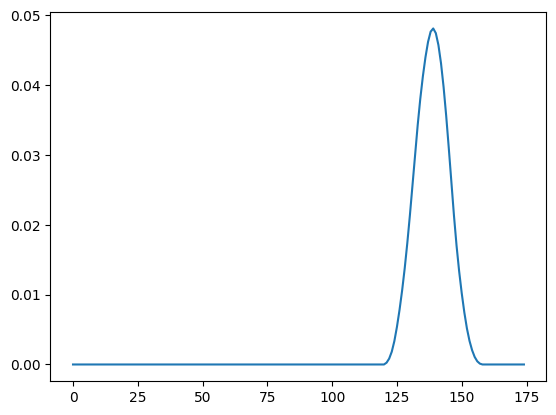

In [4]:
indx += 1

(peak_signal, peak_curvature, peak_v, df, vcenter, ph, signal_mean, signal_std,\
                dS_dV_max_peak, dS_dV_min_peak, dS_dV_peak_diff, dS_dV_max_V, \
                dS_dV_min_V, dS_dV_area) = v2signal_extra_features(all_files[indx],
                                                                    do_log,
                                                                    smoothing_bw,
                                                                    vcenter,
                                                                    vwidth1,
                                                                    stiffness,
                              
                                                                noise='none')


print(indx, os.path.basename(all_files[indx]), ph, peak_curvature)
plt.plot(df['detilted'])

In [5]:
# Load dataset
normalization    = False
standardize_type = 'mean_std' if normalization else 'none'
split            = True
combat_norm      = False
showFileName     = True

if split:
    (ML1_X_train, ML1_X_test, ML1_y_train, ML1_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)
    (ML2_X_train, ML2_X_test, ML2_y_train, ML2_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)
    (ML4_X_train, ML4_X_test, ML4_y_train, ML4_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)

else:
    ML1_X, ML1_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)
    ML2_X, ML2_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)
    ML4_X, ML4_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)

######Data Distribution:#########
Training {'2024_02_19_cbz16_10.txt': 1, '2024_02_19_cbz00_07.txt': 1, '2024_02_19_cbz00_34.txt': 1, '2024_02_19_cbz08_01.txt': 1, '2024_02_19_cbz00_36.txt': 1, '2024_02_19_cbz08_22.txt': 1, '2024_02_19_cbz16_37.txt': 1, '2024_02_19_cbz16_26.txt': 1, '2024_02_19_cbz08_16.txt': 1, '2024_02_19_cbz16_07.txt': 1, '2024_02_19_cbz08_42.txt': 1, '2024_02_19_cbz00_35.txt': 1, '2024_02_19_cbz00_01.txt': 1, '2024_02_19_cbz00_09.txt': 1, '2024_02_19_cbz08_33.txt': 1, '2024_02_19_cbz16_13.txt': 1, '2024_02_19_cbz08_44.txt': 1, '2024_02_19_cbz08_25.txt': 1, '2024_02_19_cbz00_12.txt': 1, '2024_02_19_cbz08_20.txt': 1, '2024_02_19_cbz00_02.txt': 1, '2024_02_19_cbz16_02.txt': 1, '2024_02_19_cbz00_08.txt': 1, '2024_02_19_cbz16_03.txt': 1, '2024_02_19_cbz16_41.txt': 1, '2024_02_19_cbz16_27.txt': 1, '2024_02_19_cbz08_28.txt': 1, '2024_02_19_cbz08_08.txt': 1, '2024_02_19_cbz08_05.txt': 1, '2024_02_19_cbz08_24.txt': 1, '2024_02_19_cbz00_41.txt': 1, '2024_02_19_cbz16_01.txt':

In [6]:
training_data_file = [ML1_y_train.apply(lambda x:os.path.realpath('../dataset/ML1_ML2/2024_02_19_ML1/'+x)).values.tolist(),  ML2_y_train.apply(lambda x:os.path.realpath('../dataset/ML1_ML2/2024_02_22_ML2/'+x)).values.tolist(), ML4_y_train.apply(lambda x:os.path.realpath('../dataset/ML4/'+x)).values.tolist()]
testing_data_file  = [ML1_y_test.apply(lambda x:os.path.realpath('../dataset/ML1_ML2/2024_02_19_ML1/'+x)).values.tolist(),  ML2_y_test.apply(lambda x:os.path.realpath('../dataset/ML1_ML2/2024_02_22_ML2/'+x)).values.tolist(), ML4_y_test.apply(lambda x:os.path.realpath('../dataset/ML4/'+x)).values.tolist()]

In [7]:
training_data_file[0][0]

'/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1/2024_02_19_cbz00_16.txt'

In [20]:
all_df = []

do_log        = True
recenter      = False
smoothing_bw  = 0.006
stiffness     = 0
vcenter       = 1.04
vwidth1       = 0.2
vwidth2       = None

for data in training_data_file:
    df = run_vg2(data,  \
                do_log=do_log,
                recenter=recenter, 
                smoothing_bw=smoothing_bw, 
                stiffness=stiffness, 
                vcenter=vcenter, 
                vwidth1=vwidth1, 
                vwidth2=vwidth2,
                noise='gaussian',
                clip_signal=False,
                show_negative_peak_signal=True,
                savefilename=f'feature_extraction_vwidth_{vwidth1}_training_noisy')
    

0.005959818397127316
Negative peak 2024_02_19_cbz08_08.txt
0.015526512936116031
0.022831904253294528
0.007696143239038875
0.032163937319641
0.05338848180357147
0.06080567564178249
0.03345179271967734
0.003018926676989447
0.03104201761508812
0.010637985230718319
0.00932003009840561
0.015576590153478518
0.018722389479952705
0.030725865885847827


/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_11761/4064963020.py:62: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  vg_df["detilted"][(vg_df['V']<1.15) & (vg_df['V']>0.93)] = section
/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000g

0.035901914474045234
0.03645599173122148
0.006692863423273156
0.03996677891242864
0.010478713574581548
0.02425888307249327
0.010552161227449272
0.010560134260775997
0.0689843011148651
0.06018178433322908
0.045115178119384244
0.013485950453520697
0.02490756040073514
0.05317605467000485
0.017110035290862666
0.06335184571429975
0.005653469763865726
0.04925123236799712


/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_11761/4064963020.py:62: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  vg_df["detilted"][(vg_df['V']<1.15) & (vg_df['V']>0.93)] = section
/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000g

0.025296403674888484
0.008268802520900356
0.042321536100453284
0.02077878338695759
0.013596464021755067
0.021975270510409293
0.007698054470910488
0.021443220224572807
0.0040789109524149705
0.030826024365190052
0.04819917622906166
0.02634289991323892
0.007480872848425496
0.039185585983080334
Negative peak 2024_02_19_cbz00_36.txt
0.005060253677899339
0.023761590396050542
0.02471711439733083
0.003370497235046108


/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_11761/4064963020.py:62: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  vg_df["detilted"][(vg_df['V']<1.15) & (vg_df['V']>0.93)] = section
/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000g

0.009431388454036734
0.02780422685518424
0.004017746949555189
0.008980743590993042
0.005184608573641637
0.02615343600179381
0.02979719349669181
0.009758020040930905
0.02025901337067106
0.039967459310855304
0.02954830225767263
0.053147480548144714
0.05591198277692696
0.005682414525500925
0.04594105532366201
0.009254800439561967
0.008926695699629594


/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_11761/4064963020.py:62: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  vg_df["detilted"][(vg_df['V']<1.15) & (vg_df['V']>0.93)] = section
/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000g

0.027250870708201425
0.02850747463206481
0.013221331433472459
0.04571778348062005
0.002906843468335328
0.029911487749402013
0.02127673600039592
0.025888290453771553
0.03658797025722992
0.00958659350638539


/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_11761/4064963020.py:62: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  vg_df["detilted"][(vg_df['V']<1.15) & (vg_df['V']>0.93)] = section
/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000g

0.004478713278872128
0.017376855436590788
0.02008599387248908
0.028449452324537557
0.010604468105908031
0.012625708304496865
0.024232188398307878
0.0073728858969835795
0.06061613481967959
0.008631136051579625
0.03709581454902771
0.032422510452345774
0.06287666728006112
0.042550229014418815
0.0332489798555851
0.00977180511183491
0.033111906364045714
0.05256060081481335
0.009938450001947173
0.042276607921869526
Negative peak 2024_02_22_cbz08_16.txt
0.037902823116964954


/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_11761/4064963020.py:62: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  vg_df["detilted"][(vg_df['V']<1.15) & (vg_df['V']>0.93)] = section
/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000g

0.03316948640319104
0.057441826793603365
0.052111919326877566
0.03041542330521934
0.022632851255487894
0.048987944434863186
0.0029094210425149305
0.019499639035818188
0.008867600472772366
0.030540831533225427
0.0057792686736236705
0.011078723985483324
0.03140575418969849
0.009076913189067625
0.048034784013003276
0.028275119130445118
0.023783731204956145
0.0325987330218613


/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_11761/4064963020.py:62: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  vg_df["detilted"][(vg_df['V']<1.15) & (vg_df['V']>0.93)] = section
/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000g

0.05253539498081399
0.01472156396410419
0.05025046270706709
0.013015111701408923
0.04618829445597568
0.008170185818595356
0.029983832042337
0.006610658038773869
0.02805976072275465
0.002681436264551408
0.008589211557634088
0.009302050691702063
Negative peak 2024_02_22_cbz00_18.txt
0.003246679110943576
0.02192003174575846
0.03656397371593933
0.06909184590099961
0.03236172198395312


/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_11761/4064963020.py:62: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  vg_df["detilted"][(vg_df['V']<1.15) & (vg_df['V']>0.93)] = section
/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000g

0.03390091880311772
0.007575039328468526
0.0483381996597302
0.040005723111807626
0.007574042786646099
0.03680142742797112
0.05426179384533199
0.007347904018507195
0.016778328036467623
0.025985403212405014
0.008662073838887358
0.061181652935417746
0.011262846756767007


/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_11761/4064963020.py:62: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  vg_df["detilted"][(vg_df['V']<1.15) & (vg_df['V']>0.93)] = section
/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000g

0.009220593734372192
0.06773003771197472
0.06962668783105777
0.044907689268228794
0.006753071864394507
0.009863522238769549
0.07281208706314482
0.005130149618571337
0.11744430145551644
0.00894714044577481
0.06392718616713183
0.11672498422066707
0.05859086563479748
0.10133058740271261
0.08841908468528427
Negative peak 2024_03_08_cbz00_05.txt
0.002941146533290107
0.055150892261315615
0.12444421014165541
0.011928229492594956
0.053115647332976884
0.054124147005794605


/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_11761/4064963020.py:62: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  vg_df["detilted"][(vg_df['V']<1.15) & (vg_df['V']>0.93)] = section
/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000g

0.04879243233954247
0.04484848089520024
0.0836084495673829
0.06187721681223262
0.0409599073706355
0.11518092295393825
0.005745396684610485
0.043837157992993404
Negative peak 2024_03_08_cbz00_38.txt
0.004245790607300059
0.06258948287020258
0.006697564172179543
0.002505749974378612
0.08601666388300729
0.01163982058434051
0.07196445380752162
0.06460436650089867
0.049670651481034826
0.0845431311623868
0.10563539734925148
0.05580896358183797


/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_11761/4064963020.py:62: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  vg_df["detilted"][(vg_df['V']<1.15) & (vg_df['V']>0.93)] = section
/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000g

0.038149151445582175
0.013947375810792152
0.118962843949165
0.006340116921467148
0.049998402129112385
0.004875112115105298
0.05751330399101569
0.006598449581151046
0.007932440559286456
0.0013496358723348206
0.002913084496509877
0.041329533816836656
0.08136106823710564
0.09932173874434343
0.044558238356238594
0.04607658499731226
0.0033850727613927573
0.08801553489889312


/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_11761/4064963020.py:62: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  vg_df["detilted"][(vg_df['V']<1.15) & (vg_df['V']>0.93)] = section
/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000g

0.08755173809609938
0.00899359860013857
0.06190649831222201
0.09344927551756442
Negative peak 2024_03_08_cbz00_43.txt
0.028797412009180512
0.06021630740319749
0.06274265712924575
0.0626116474210055
0.10962595416883618
0.0037774509750980153


/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_11761/4064963020.py:62: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  vg_df["detilted"][(vg_df['V']<1.15) & (vg_df['V']>0.93)] = section
/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000g

In [ ]:
Negative peak 2024_02_19_cbz00_05.txt
Negative peak 2024_02_19_cbz00_38.txt
Negative peak 2024_02_19_cbz08_37.txt
Negative peak 2024_02_19_cbz00_36.txt
Negative peak 2024_02_19_cbz00_04.txt
Negative peak 2024_02_22_cbz08_10.txt
Negative peak 2024_02_22_cbz08_01.txt
Negative peak 2024_03_08_cbz00_21.txt
Negative peak 2024_03_08_cbz00_05.txt
Negative peak 2024_03_08_cbz00_38.txt
Negative peak 2024_03_08_cbz00_42.txt
Negative peak 2024_03_08_cbz00_31.txt
Negative peak 2024_03_08_cbz00_04.txt
Negative peak 2024_03_08_cbz00_43.txt